**Review**

Hello Aryslan!

I'm happy to review your project today.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the next sprint!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.isnull().sum()

num_orders    0
dtype: int64

In [4]:
data.shape

(26496, 1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.value_counts()

num_orders
9             1373
11            1365
12            1317
10            1316
8             1253
              ... 
94               1
95               1
98               1
99               1
81               1
Length: 81, dtype: int64

In [7]:
data.duplicated()

datetime
2018-03-01 00:00:00    False
2018-03-01 00:10:00    False
2018-03-01 00:20:00    False
2018-03-01 00:30:00    False
2018-03-01 00:40:00    False
                       ...  
2018-08-31 23:10:00     True
2018-08-31 23:20:00     True
2018-08-31 23:30:00     True
2018-08-31 23:40:00     True
2018-08-31 23:50:00     True
Length: 26496, dtype: bool

In [8]:
data = data.dropna()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
data = data.resample('H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was resampled correctly

</div>

In [10]:
data.sort_index(inplace=True)

In [11]:
#data = data['2018-03':'2018-09'].resample('H').sum()
#data.head()

## Analysis

<AxesSubplot:xlabel='datetime'>

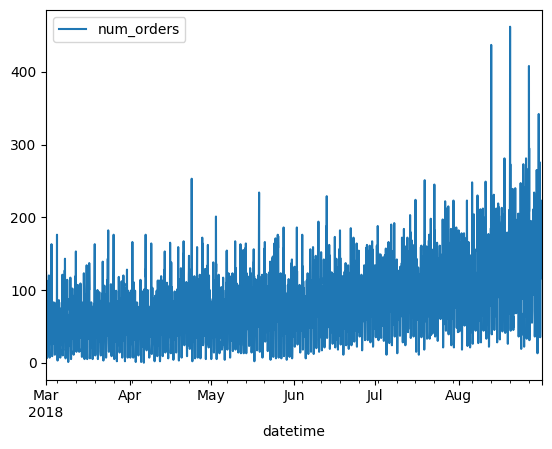

In [12]:
data.plot()

- Trend

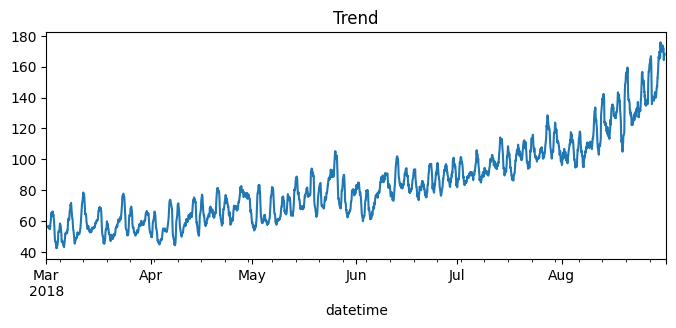

In [13]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())

plt.title('Trend')
plt.show()

- Seasonal component

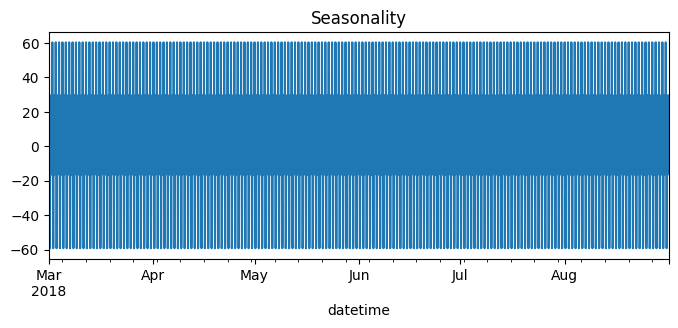

In [14]:
plt.figure(figsize=(8, 10))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.show()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

I would suggest looking at a smaller slice of `decomposed.seasonal` to better see the seasonal pattern

</div>

- Residuals

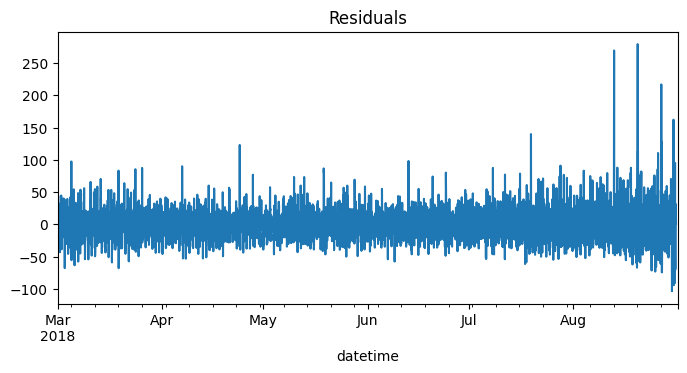

In [15]:
plt.figure(figsize=(8, 12))
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.show()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Great, you did a seasonal decomposition and plotted the data. Would be nice to add some conclusions here

</div>

## Training

- Creating more fearures

In [16]:
def make_features(data, max_lag=4, rolling_mean_size=10):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['dayofweek_'] = data.index.dayofweek
    
    for lag in range(1, max_lag +1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data)
data = data.dropna()

data.shape
data.head()

,num_orders,hour,day,month,dayofweek_,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 10:00:00,64,10,1,3,3,69.0,34.0,15.0,12.0,52.5
2018-03-01 11:00:00,96,11,1,3,3,64.0,69.0,34.0,15.0,46.5
2018-03-01 12:00:00,30,12,1,3,3,96.0,64.0,69.0,34.0,47.6
2018-03-01 13:00:00,32,13,1,3,3,30.0,96.0,64.0,69.0,43.5
2018-03-01 14:00:00,48,14,1,3,3,32.0,30.0,96.0,64.0,40.1


<div class="alert alert-success">
<b>Reviewer's comment</b>

Feature engineering looks good: there are calendar features, lag features and a shifted rolling mean

</div>

- Split data into training and test sets

In [17]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.2)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.2)

#train.shape, test.shape, valid.shape
print(train.index.min(), train.index.max())
print(train.shape)
print(valid.index.min(), valid.index.max())
print(valid.shape)
print(test.index.min(), test.index.max())
print(test.shape)

2018-03-01 10:00:00 2018-06-26 20:00:00
(2819, 10)
2018-06-26 21:00:00 2018-07-26 05:00:00
(705, 10)
2018-07-26 06:00:00 2018-08-31 23:00:00
(882, 10)


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split without shuffling

</div>

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


In [19]:
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

print('Mean value:', test['num_orders'].mean())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE prev:', rmse(test['num_orders'], pred_previous['num_orders']))

pred_mean = np.ones(test['num_orders'].shape) * train['num_orders'].mean()
print('RMSE mean:', rmse(test['num_orders'], pred_mean))

Mean value: 124.87868480725623
RMSE prev: 53.39093403130062
RMSE mean: 78.35778076256989


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good simple baselines!

</div>

- LinearRegression

In [20]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print("RMSE train:", rmse(target_train, pred_train))
print("RMSE valid:", rmse(target_valid, pred_valid))
print()

RMSE train: 27.725425293815523
RMSE valid: 34.01633927041437



- Random Forest Regressor

In [21]:
model = RandomForestRegressor(n_estimators=500)
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print('RMSE train:', rmse(target_train, pred_train))
print('RMSE valid:', rmse(target_valid, pred_valid))

RMSE train: 7.502024919126438
RMSE valid: 27.392126420944265


- Light GBM Regressor

In [22]:
model = LGBMRegressor(learning_rate=0.02, num_iterations=2000, objective='rmse')
model.fit(features_train, target_train, eval_set=(features_valid, target_valid))

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print('RMSE train:', rmse(target_train, pred_train))
print('RMSE valid:', rmse(target_valid, pred_valid))

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's rmse: 44.8468
[2]	valid_0's rmse: 44.4016
[3]	valid_0's rmse: 44.004
[4]	valid_0's rmse: 43.568
[5]	valid_0's rmse: 43.1728
[6]	valid_0's rmse: 42.7872
[7]	valid_0's rmse: 42.4149
[8]	valid_0's rmse: 42.0224
[9]	valid_0's rmse: 41.6747
[10]	valid_0's rmse: 41.3389
[11]	valid_0's rmse: 40.9688
[12]	valid_0's rmse: 40.6676
[13]	valid_0's rmse: 40.3235
[14]	valid_0's rmse: 39.9594
[15]	valid_0's rmse: 39.6421
[16]	valid_0's rmse: 39.3423
[17]	valid_0's rmse: 39.0536
[18]	valid_0's rmse: 38.7423
[19]	valid_0's rmse: 38.4413
[20]	valid_0's rmse: 38.1662
[21]	valid_0's rmse: 37.899
[22]	valid_0's rmse: 37.6258
[23]	valid_0's rmse: 37.3842
[24]	valid_0's rmse: 37.1599
[25]	valid_0's rmse: 36.9212
[26]	valid_0's rmse: 36.6642
[27]	valid_0's rmse: 36.4286
[28]	valid_0's rmse: 36.2219
[29]	valid_0's rmse: 36.0323
[30]	valid_0's rmse: 35.8264
[31]	valid_0's rmse: 35.6282
[32]	valid_0's rmse: 35.4513
[33]	valid_0's rmse: 35.2577
[34]	valid_0's rmse: 35.0784
[35]	valid_0's rmse: 34.90

[279]	valid_0's rmse: 26.882
[280]	valid_0's rmse: 26.8738
[281]	valid_0's rmse: 26.8723
[282]	valid_0's rmse: 26.8764
[283]	valid_0's rmse: 26.877
[284]	valid_0's rmse: 26.8745
[285]	valid_0's rmse: 26.8808
[286]	valid_0's rmse: 26.8832
[287]	valid_0's rmse: 26.8876
[288]	valid_0's rmse: 26.8813
[289]	valid_0's rmse: 26.886
[290]	valid_0's rmse: 26.8891
[291]	valid_0's rmse: 26.8882
[292]	valid_0's rmse: 26.8879
[293]	valid_0's rmse: 26.8814
[294]	valid_0's rmse: 26.883
[295]	valid_0's rmse: 26.8831
[296]	valid_0's rmse: 26.8865
[297]	valid_0's rmse: 26.8909
[298]	valid_0's rmse: 26.8911
[299]	valid_0's rmse: 26.8814
[300]	valid_0's rmse: 26.8813
[301]	valid_0's rmse: 26.8728
[302]	valid_0's rmse: 26.8776
[303]	valid_0's rmse: 26.8739
[304]	valid_0's rmse: 26.8756
[305]	valid_0's rmse: 26.8816
[306]	valid_0's rmse: 26.8848
[307]	valid_0's rmse: 26.8842
[308]	valid_0's rmse: 26.8755
[309]	valid_0's rmse: 26.8728
[310]	valid_0's rmse: 26.8648
[311]	valid_0's rmse: 26.8668
[312]	valid_0'

[605]	valid_0's rmse: 27.1056
[606]	valid_0's rmse: 27.1044
[607]	valid_0's rmse: 27.0998
[608]	valid_0's rmse: 27.1004
[609]	valid_0's rmse: 27.0997
[610]	valid_0's rmse: 27.1026
[611]	valid_0's rmse: 27.1019
[612]	valid_0's rmse: 27.1025
[613]	valid_0's rmse: 27.0999
[614]	valid_0's rmse: 27.1013
[615]	valid_0's rmse: 27.1008
[616]	valid_0's rmse: 27.0982
[617]	valid_0's rmse: 27.0972
[618]	valid_0's rmse: 27.0973
[619]	valid_0's rmse: 27.1045
[620]	valid_0's rmse: 27.1069
[621]	valid_0's rmse: 27.1007
[622]	valid_0's rmse: 27.1023
[623]	valid_0's rmse: 27.1003
[624]	valid_0's rmse: 27.0984
[625]	valid_0's rmse: 27.1018
[626]	valid_0's rmse: 27.1027
[627]	valid_0's rmse: 27.1088
[628]	valid_0's rmse: 27.1046
[629]	valid_0's rmse: 27.1047
[630]	valid_0's rmse: 27.1035
[631]	valid_0's rmse: 27.1063
[632]	valid_0's rmse: 27.1025
[633]	valid_0's rmse: 27.1022
[634]	valid_0's rmse: 27.1081
[635]	valid_0's rmse: 27.1053
[636]	valid_0's rmse: 27.1027
[637]	valid_0's rmse: 27.1015
[638]	vali

[903]	valid_0's rmse: 27.2113
[904]	valid_0's rmse: 27.2116
[905]	valid_0's rmse: 27.2122
[906]	valid_0's rmse: 27.2132
[907]	valid_0's rmse: 27.2148
[908]	valid_0's rmse: 27.2153
[909]	valid_0's rmse: 27.2166
[910]	valid_0's rmse: 27.217
[911]	valid_0's rmse: 27.2167
[912]	valid_0's rmse: 27.2173
[913]	valid_0's rmse: 27.2168
[914]	valid_0's rmse: 27.2168
[915]	valid_0's rmse: 27.2208
[916]	valid_0's rmse: 27.2166
[917]	valid_0's rmse: 27.2167
[918]	valid_0's rmse: 27.2162
[919]	valid_0's rmse: 27.2148
[920]	valid_0's rmse: 27.2139
[921]	valid_0's rmse: 27.214
[922]	valid_0's rmse: 27.2165
[923]	valid_0's rmse: 27.2124
[924]	valid_0's rmse: 27.2148
[925]	valid_0's rmse: 27.2137
[926]	valid_0's rmse: 27.2138
[927]	valid_0's rmse: 27.2168
[928]	valid_0's rmse: 27.2137
[929]	valid_0's rmse: 27.2112
[930]	valid_0's rmse: 27.211
[931]	valid_0's rmse: 27.21
[932]	valid_0's rmse: 27.2094
[933]	valid_0's rmse: 27.2095
[934]	valid_0's rmse: 27.2086
[935]	valid_0's rmse: 27.2056
[936]	valid_0's

[1225]	valid_0's rmse: 27.4686
[1226]	valid_0's rmse: 27.4684
[1227]	valid_0's rmse: 27.4672
[1228]	valid_0's rmse: 27.4686
[1229]	valid_0's rmse: 27.4699
[1230]	valid_0's rmse: 27.4683
[1231]	valid_0's rmse: 27.466
[1232]	valid_0's rmse: 27.4674
[1233]	valid_0's rmse: 27.4692
[1234]	valid_0's rmse: 27.467
[1235]	valid_0's rmse: 27.4692
[1236]	valid_0's rmse: 27.4714
[1237]	valid_0's rmse: 27.4711
[1238]	valid_0's rmse: 27.4731
[1239]	valid_0's rmse: 27.4737
[1240]	valid_0's rmse: 27.4714
[1241]	valid_0's rmse: 27.4721
[1242]	valid_0's rmse: 27.471
[1243]	valid_0's rmse: 27.4705
[1244]	valid_0's rmse: 27.4714
[1245]	valid_0's rmse: 27.4694
[1246]	valid_0's rmse: 27.4704
[1247]	valid_0's rmse: 27.4717
[1248]	valid_0's rmse: 27.4706
[1249]	valid_0's rmse: 27.4721
[1250]	valid_0's rmse: 27.4718
[1251]	valid_0's rmse: 27.4739
[1252]	valid_0's rmse: 27.4754
[1253]	valid_0's rmse: 27.4748
[1254]	valid_0's rmse: 27.4711
[1255]	valid_0's rmse: 27.4753
[1256]	valid_0's rmse: 27.4776
[1257]	vali

[1491]	valid_0's rmse: 27.6064
[1492]	valid_0's rmse: 27.6066
[1493]	valid_0's rmse: 27.6089
[1494]	valid_0's rmse: 27.6092
[1495]	valid_0's rmse: 27.6124
[1496]	valid_0's rmse: 27.6128
[1497]	valid_0's rmse: 27.6116
[1498]	valid_0's rmse: 27.6125
[1499]	valid_0's rmse: 27.6148
[1500]	valid_0's rmse: 27.6154
[1501]	valid_0's rmse: 27.6169
[1502]	valid_0's rmse: 27.6164
[1503]	valid_0's rmse: 27.6168
[1504]	valid_0's rmse: 27.6181
[1505]	valid_0's rmse: 27.6178
[1506]	valid_0's rmse: 27.6172
[1507]	valid_0's rmse: 27.617
[1508]	valid_0's rmse: 27.6168
[1509]	valid_0's rmse: 27.617
[1510]	valid_0's rmse: 27.6175
[1511]	valid_0's rmse: 27.6182
[1512]	valid_0's rmse: 27.6191
[1513]	valid_0's rmse: 27.6189
[1514]	valid_0's rmse: 27.6202
[1515]	valid_0's rmse: 27.6192
[1516]	valid_0's rmse: 27.62
[1517]	valid_0's rmse: 27.6222
[1518]	valid_0's rmse: 27.6198
[1519]	valid_0's rmse: 27.6194
[1520]	valid_0's rmse: 27.6217
[1521]	valid_0's rmse: 27.6235
[1522]	valid_0's rmse: 27.6228
[1523]	valid

[1805]	valid_0's rmse: 27.7856
[1806]	valid_0's rmse: 27.7865
[1807]	valid_0's rmse: 27.7867
[1808]	valid_0's rmse: 27.7871
[1809]	valid_0's rmse: 27.7905
[1810]	valid_0's rmse: 27.7905
[1811]	valid_0's rmse: 27.7914
[1812]	valid_0's rmse: 27.791
[1813]	valid_0's rmse: 27.7924
[1814]	valid_0's rmse: 27.7923
[1815]	valid_0's rmse: 27.7938
[1816]	valid_0's rmse: 27.7934
[1817]	valid_0's rmse: 27.7934
[1818]	valid_0's rmse: 27.795
[1819]	valid_0's rmse: 27.7946
[1820]	valid_0's rmse: 27.7939
[1821]	valid_0's rmse: 27.7966
[1822]	valid_0's rmse: 27.7973
[1823]	valid_0's rmse: 27.7978
[1824]	valid_0's rmse: 27.797
[1825]	valid_0's rmse: 27.7975
[1826]	valid_0's rmse: 27.7963
[1827]	valid_0's rmse: 27.7966
[1828]	valid_0's rmse: 27.7965
[1829]	valid_0's rmse: 27.7965
[1830]	valid_0's rmse: 27.797
[1831]	valid_0's rmse: 27.7972
[1832]	valid_0's rmse: 27.7968
[1833]	valid_0's rmse: 27.7957
[1834]	valid_0's rmse: 27.7959
[1835]	valid_0's rmse: 27.7953
[1836]	valid_0's rmse: 27.7946
[1837]	valid

- Cat Boost Regressor

In [23]:
model = CatBoostRegressor(learning_rate=0.02, iterations=2000, metric_period=100, loss_function='RMSE')
model.fit(features_train, target_train, eval_set=(features_valid, target_valid))

pred_train = model.predict(features_train)
pred_valid = model.predict(features_valid)

print('RMSE train:', rmse(target_train, pred_train))
print('RMSE valid:', rmse(target_valid, pred_valid))

0:	learn: 33.1723975	test: 44.8559031	best: 44.8559031 (0)	total: 48.6ms	remaining: 1m 37s
100:	learn: 22.4955970	test: 31.2757660	best: 31.2757660 (100)	total: 285ms	remaining: 5.35s
200:	learn: 20.4015646	test: 28.6588921	best: 28.6588921 (200)	total: 514ms	remaining: 4.6s
300:	learn: 19.2260066	test: 27.6153029	best: 27.6153029 (300)	total: 728ms	remaining: 4.11s
400:	learn: 18.4198714	test: 27.2355216	best: 27.2355216 (400)	total: 944ms	remaining: 3.76s
500:	learn: 17.7057075	test: 26.9482212	best: 26.9482212 (500)	total: 1.16s	remaining: 3.47s
600:	learn: 17.0442797	test: 26.7271017	best: 26.7271017 (600)	total: 1.38s	remaining: 3.21s
700:	learn: 16.4998474	test: 26.5935699	best: 26.5935699 (700)	total: 1.59s	remaining: 2.95s
800:	learn: 16.0104107	test: 26.5488269	best: 26.5488269 (800)	total: 1.8s	remaining: 2.7s
900:	learn: 15.5309181	test: 26.5105139	best: 26.5105139 (900)	total: 2.02s	remaining: 2.47s
1000:	learn: 15.0900776	test: 26.4737236	best: 26.4737236 (1000)	total: 2.2

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Great, you tried a couple of different models, would be nice to add some hyperparameter tuning though

</div>

## Testing

In [24]:
features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

- Linear Regression

In [25]:
model = LinearRegression()
model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 29.00605150551128
RMSE test: 47.825899473035484


- Random Forest

In [26]:
model = RandomForestRegressor(n_estimators=500)
model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 7.706364473425574
RMSE test: 44.878150019268034


- Cat Boost 

In [27]:
model = CatBoostRegressor(learning_rate=0.02, iterations=2000, loss_function='RMSE', verbose=False)
model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print('RMSE train:', rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print('RMSE test:', rmse(target_test, pred_test))

RMSE train: 13.515723598799198
RMSE test: 45.44059093209576


Conclusion 

1. The quality between train and test not significantly
2. Linear Regression model is the best
3. RMSE for the test set for all models not more than 48

<div class="alert alert-success">
<b>Reviewer's comment</b>

The final models were evaluated on the test set

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48